In [ ]:
try:
    get_ipython  # type: ignore
    %matplotlib inline  # type: ignore
except Exception:
    pass

import os
import sys
import time
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# optional visual nicety
try:
    import seaborn as sns
    sns.set_style("whitegrid")
except Exception:
    sns = None

# sklearn imports
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, f1_score,
    precision_recall_fscore_support, confusion_matrix
)

# try to import xgboost, but continue if missing
USE_XGBOOST = False
try:
    import xgboost as xgb  # type: ignore
    from xgboost import XGBClassifier  # type: ignore
    USE_XGBOOST = True
    print("xgboost available — using XGBClassifier where appropriate.")
except Exception:
    print("xgboost not available — will use HistGradientBoostingClassifier as fallback.")

# -------------------------
# Config
# -------------------------
DATA_FILENAME = "ctu13_flows.csv"  # change if you have a different file
SAVE_OUTPUTS = True
OUTPUT_DIR = "eucyber_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
RANDOM_STATE = 42

xgboost available — using XGBClassifier where appropriate.


In [ ]:
# -------------------------
# 1) Load dataset (CSV) if present, else synthetic fallback
# -------------------------
def load_dataset(path=DATA_FILENAME):
    if os.path.exists(path):
        print(f"Loading dataset from {path} ...")
        df = pd.read_csv(path)
        # try to detect label column
        candidates = [c for c in df.columns if c.lower() in ("label", "class", "malicious", "is_malware", "target", "y")]
        if len(candidates) == 0:
            # fallback: assume last column is label
            df = df.rename(columns={df.columns[-1]: "label"})
            print("No obvious label column found — using last column as 'label'.")
        else:
            df = df.rename(columns={candidates[0]: "label"})
            print(f"Using '{candidates[0]}' as label column.")
        # drop entirely non-numeric columns (IDs, strings)
        non_numeric = [c for c in df.columns if c != "label" and not pd.api.types.is_numeric_dtype(df[c])]
        if non_numeric:
            print(f"Dropping non-numeric columns (first 10 shown): {non_numeric[:10]}")
            df = df.drop(columns=non_numeric)
        df = df.dropna(axis=0).reset_index(drop=True)
        # ensure label binary (map common strings to 0/1)
        if not pd.api.types.is_numeric_dtype(df["label"]):
            df["label"] = df["label"].astype(str).str.lower().map(lambda s: 1 if ("mal" in s or "ransom" in s or "bot" in s or "attack" in s or s in ("1","true","yes")) else 0)
        df["label"] = df["label"].astype(int)
        print("Loaded dataset shape:", df.shape, "Label counts:", Counter(df["label"].values))
        return df
    else:
        print(f"No dataset found at {path}. Generating hard synthetic dataset (safe fallback).")
        from sklearn.datasets import make_classification
        X, y = make_classification(
            n_samples=4000,
            n_features=120,
            n_informative=10,
            n_redundant=50,
            flip_y=0.12,
            class_sep=0.6,
            random_state=RANDOM_STATE
        )
        cols = [f"f{i}" for i in range(X.shape[1])]
        df = pd.DataFrame(X, columns=cols)
        df["label"] = y
        print("Synthetic dataset shape:", df.shape, "Label counts:", Counter(y))
        return df

df = load_dataset(DATA_FILENAME)


No dataset found at ctu13_flows.csv. Generating hard synthetic dataset (safe fallback).
Synthetic dataset shape: (4000, 121) Label counts: Counter({np.int64(0): 2011, np.int64(1): 1989})


In [ ]:
# -------------------------
# 2) Preprocess & splits
# -------------------------
feature_cols = [c for c in df.columns if c != "label"]
if len(feature_cols) == 0:
    raise RuntimeError("No feature columns found. Ensure your CSV has numeric feature columns and a label column.")

X = df[feature_cols].values
y = df["label"].values

# stratify only if both classes present
if len(np.unique(y)) > 1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print("Train/test shapes:", X_train_s.shape, X_test_s.shape)
print("Train label distribution:", Counter(y_train), "Test label distribution:", Counter(y_test))

Train/test shapes: (3000, 120) (1000, 120)
Train label distribution: Counter({np.int64(0): 1508, np.int64(1): 1492}) Test label distribution: Counter({np.int64(0): 503, np.int64(1): 497})


In [ ]:
# -------------------------
# 3) Train models (RF + XGB/HGB + OC-SVM)
# -------------------------
print("\nTraining RandomForest...")
rf = RandomForestClassifier(n_estimators=150, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train_s, y_train)

print("Training XGBoost or HistGradientBoosting fallback...")
if USE_XGBOOST:
    xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=4, n_estimators=150)
    xgb_clf.fit(X_train_s, y_train)
else:
    xgb_clf = HistGradientBoostingClassifier(max_iter=150, random_state=RANDOM_STATE)
    xgb_clf.fit(X_train_s, y_train)

print("Training One-Class SVM on benign (if available)...")
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma="scale")
# train OC-SVM only on benign data if available
if (y_train == 0).sum() >= 20:
    ocsvm.fit(X_train_s[y_train == 0])
else:
    ocsvm.fit(X_train_s)



Training RandomForest...
Training XGBoost or HistGradientBoosting fallback...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:11:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training One-Class SVM on benign (if available)...



AUCs -> RF: 0.903, XGB/HGB: 0.899, OC-SVM: 0.541, Fusion: 0.903


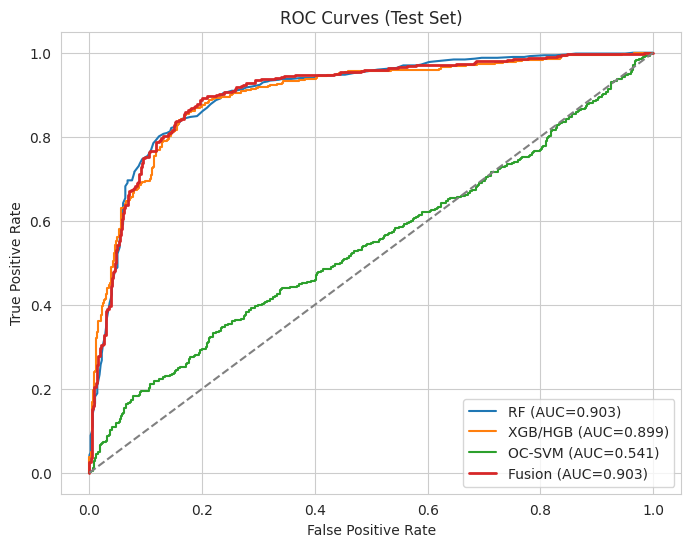

In [ ]:
# -------------------------
# 4) Scoring utilities
# -------------------------
def safe_prob(clf, Xs):
    if hasattr(clf, "predict_proba"):
        try:
            return clf.predict_proba(Xs)[:, 1]
        except Exception:
            # some models may not expose predict_proba reliably
            return clf.predict(Xs).astype(float)
    elif hasattr(clf, "decision_function"):
        s = clf.decision_function(Xs)
        # normalize to 0..1
        if np.ptp(s) == 0:
            return np.zeros_like(s)
        return (s - s.min()) / (s.max() - s.min() + 1e-9)
    else:
        return clf.predict(Xs).astype(float)

def ocsvm_anom(oc, Xs):
    raw = oc.decision_function(Xs)  # higher often == more normal
    inv = -raw
    if np.ptp(inv) == 0:
        return np.zeros_like(inv)
    return (inv - inv.min()) / (inv.max() - inv.min() + 1e-9)

# compute scores
rf_train_scores = safe_prob(rf, X_train_s)
rf_test_scores = safe_prob(rf, X_test_s)
xgb_train_scores = safe_prob(xgb_clf, X_train_s)
xgb_test_scores = safe_prob(xgb_clf, X_test_s)
oc_train_scores = ocsvm_anom(ocsvm, X_train_s)
oc_test_scores = ocsvm_anom(ocsvm, X_test_s)

# ensemble fusion weights (tunable)
w_rf, w_xgb, w_oc = 0.45, 0.45, 0.10
fusion_train = w_rf*rf_train_scores + w_xgb*xgb_train_scores + w_oc*oc_train_scores
fusion_test = w_rf*rf_test_scores + w_xgb*xgb_test_scores + w_oc*oc_test_scores

# -------------------------
# 5) Static evaluation: ROC AUC & plots
# -------------------------
from sklearn.metrics import roc_curve, auc
def roc_auc(y_true, scores):
    try:
        fpr, tpr, _ = roc_curve(y_true, scores)
        return fpr, tpr, auc(fpr, tpr)
    except Exception:
        # fallback for degenerate labels
        return np.array([0,1]), np.array([0,1]), 0.5

fpr_rf, tpr_rf, auc_rf = roc_auc(y_test, rf_test_scores)
fpr_xgb, tpr_xgb, auc_xgb = roc_auc(y_test, xgb_test_scores)
fpr_oc, tpr_oc, auc_oc = roc_auc(y_test, oc_test_scores)
fpr_f, tpr_f, auc_f = roc_auc(y_test, fusion_test)

print(f"\nAUCs -> RF: {auc_rf:.3f}, XGB/HGB: {auc_xgb:.3f}, OC-SVM: {auc_oc:.3f}, Fusion: {auc_f:.3f}")

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB/HGB (AUC={auc_xgb:.3f})")
plt.plot(fpr_oc, tpr_oc, label=f"OC-SVM (AUC={auc_oc:.3f})")
plt.plot(fpr_f, tpr_f, label=f"Fusion (AUC={auc_f:.3f})", linewidth=2)
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


Best thresholds (by F1) — RF: 0.436 (F1=0.843), XGB: 0.406 (F1=0.843), Fusion: 0.386 (F1=0.851)


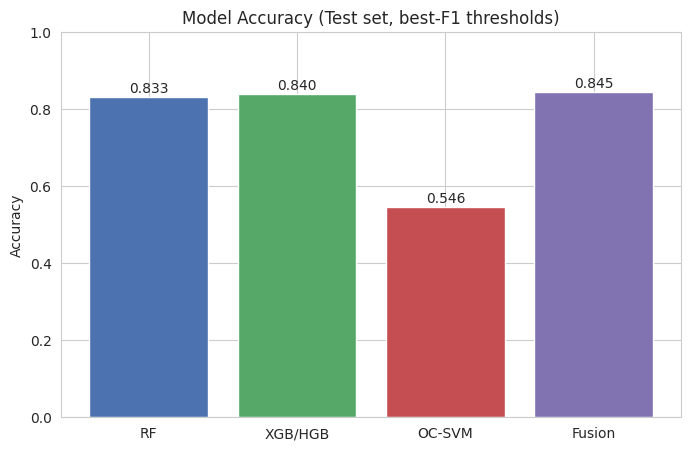

In [ ]:
# -------------------------
# 6) Best thresholds by F1 on test (for fair comparison)
# -------------------------
def best_thr_by_f1(scores, y_true, steps=100):
    best_thr, best_f1 = 0.5, -1
    for thr in np.linspace(0.01, 0.99, steps):
        preds = (scores > thr).astype(int)
        f1 = f1_score(y_true, preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return best_thr, best_f1

rf_thr, rf_f1 = best_thr_by_f1(rf_test_scores, y_test)
xgb_thr, xgb_f1 = best_thr_by_f1(xgb_test_scores, y_test)
fusion_thr, fusion_f1 = best_thr_by_f1(fusion_test, y_test)
print(f"Best thresholds (by F1) — RF: {rf_thr:.3f} (F1={rf_f1:.3f}), XGB: {xgb_thr:.3f} (F1={xgb_f1:.3f}), Fusion: {fusion_thr:.3f} (F1={fusion_f1:.3f})")

# Predictions using best thresholds
rf_pred = (rf_test_scores > rf_thr).astype(int)
xgb_pred = (xgb_test_scores > xgb_thr).astype(int)
oc_pred = (oc_test_scores > 0.5).astype(int)  # normalized 0..1 midpoint
fusion_pred = (fusion_test > fusion_thr).astype(int)

# accuracy bars
accs = [
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, xgb_pred),
    accuracy_score(y_test, oc_pred),
    accuracy_score(y_test, fusion_pred)
]
names = ["RF", "XGB/HGB", "OC-SVM", "Fusion"]
plt.figure(figsize=(8,5))
bars = plt.bar(names, accs, color=['#4C72B0','#55A868','#C44E52','#8172B2'])
for bar, a in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, a + 0.01, f"{a:.3f}", ha='center')
plt.ylim(0,1)
plt.title("Model Accuracy (Test set, best-F1 thresholds)")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
for name, preds in zip(names, [rf_pred, xgb_pred, oc_pred, fusion_pred]):
    p,r,f,_ = precision_recall_fscore_support(y_test, preds, average='binary', zero_division=0)
    acc = accuracy_score(y_test, preds)
    print(f"{name}: accuracy={acc:.3f}, precision={p:.3f}, recall={r:.3f}, f1={f:.3f}")

RF: accuracy=0.833, precision=0.790, recall=0.903, f1=0.843
XGB/HGB: accuracy=0.840, precision=0.821, recall=0.867, f1=0.843
OC-SVM: accuracy=0.546, precision=0.600, recall=0.260, f1=0.362
Fusion: accuracy=0.845, precision=0.814, recall=0.891, f1=0.851


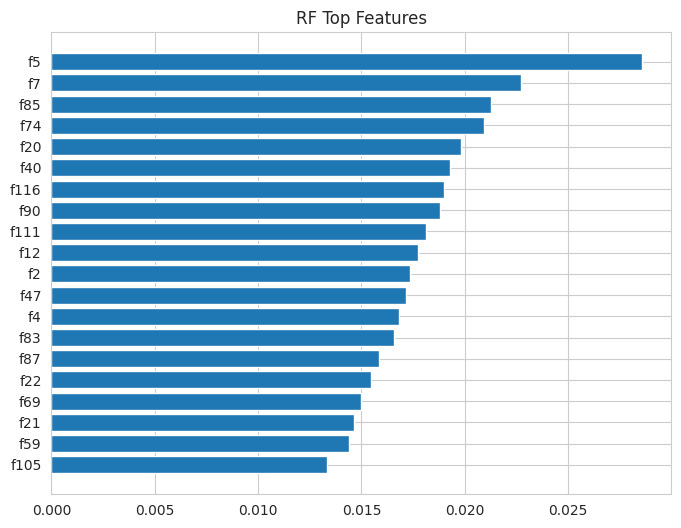

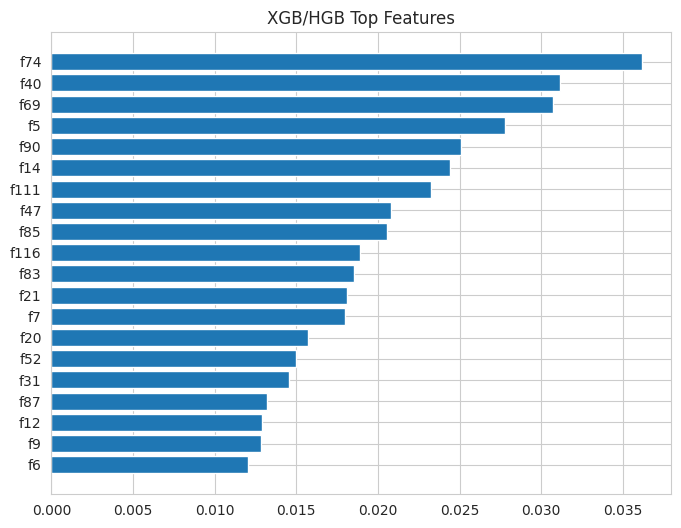

In [ ]:
# -------------------------
# 7) Feature importance (RF and XGB/HGB)
# -------------------------
def plot_feature_importances(clf, feat_names, topk=20, title="Feature Importances"):
    if hasattr(clf, "feature_importances_"):
        imps = clf.feature_importances_
        idx = np.argsort(imps)[-topk:][::-1]
        plt.figure(figsize=(8,6))
        plt.barh(np.array(feat_names)[idx][::-1], imps[idx][::-1])
        plt.title(title)
        plt.show()
    else:
        print("Model has no feature_importances_ attribute.")

plot_feature_importances(rf, feature_cols, topk=min(20, len(feature_cols)), title="RF Top Features")
plot_feature_importances(xgb_clf, feature_cols, topk=min(20, len(feature_cols)), title="XGB/HGB Top Features")




Starting streaming simulation (adaptive threshold & tiered alerts)...


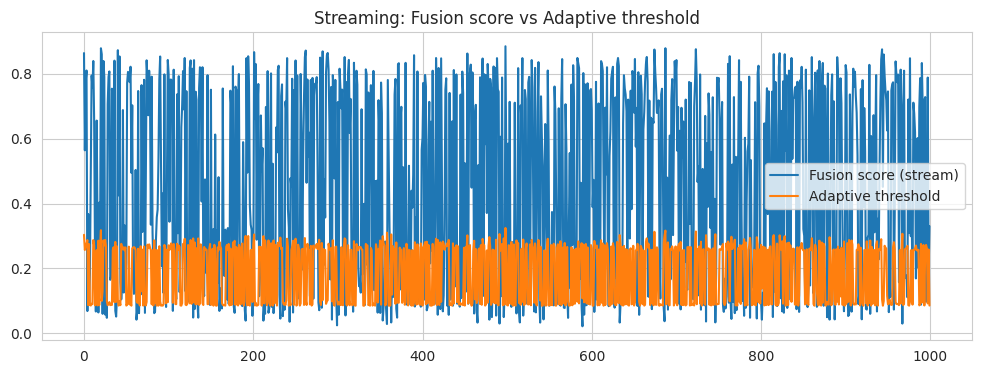

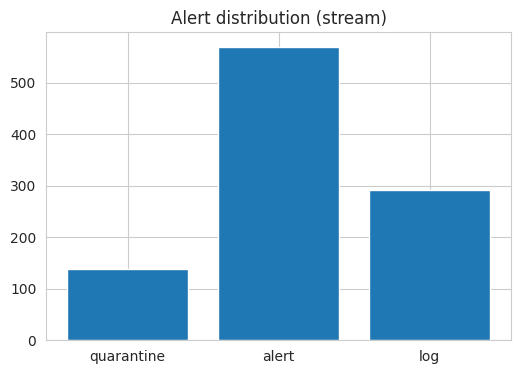

Streaming detection summary -> total=497, detected=474, missed=23, prevention_rate=0.954


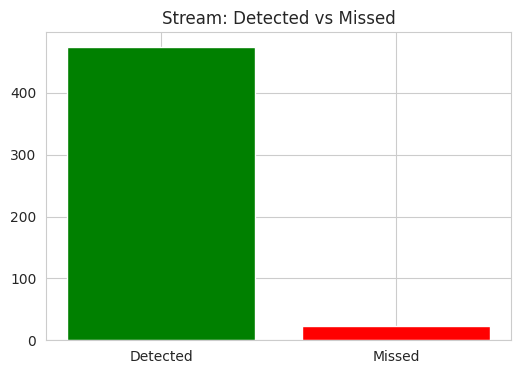

In [ ]:
# -------------------------
# 9) Streaming simulation (test set as stream) with adaptive threshold
# -------------------------
print("\nStarting streaming simulation (adaptive threshold & tiered alerts)...")
stream_X = X_test_s.copy()
stream_y = y_test.copy()

class SimpleCP:
    def __init__(self, window=6, thr=0.06):
        self.window = window; self.thr = thr; self.buf=[]
    def update(self, v):
        self.buf.append(v)
        if len(self.buf) > self.window: self.buf.pop(0)
        if len(self.buf) < self.window: return False, 1.0
        med = np.median(self.buf[:-1]); last = self.buf[-1]; change = last - med
        if change > self.thr:
            return True, min(3.0, 1.0 + change/(self.thr + 1e-9))
        return False, 1.0

cpd = SimpleCP(window=6, thr=0.06)
base_thr = fusion_thr
thr_history = []
fusion_history = []
actions = []
labels_stream = []

meta_mult = 1.0
alpha = 0.03

for i in range(len(stream_X)):
    x = stream_X[i:i+1]
    p_rf = safe_prob(rf, x)[0]
    p_xgb = safe_prob(xgb_clf, x)[0]
    p_oc = ocsvm_anom(ocsvm, x)[0]
    fusion_score = w_rf*p_rf + w_xgb*p_xgb + w_oc*p_oc
    fusion_history.append(fusion_score)

    # change-point on feature 0 (generic)
    cp_flag, cp_factor = cpd.update(x[0,0])
    # uncertainty proxy (RF tree std)
    try:
        allp = np.vstack([est.predict_proba(x)[:,1] for est in rf.estimators_]).T
        unc = float(np.std(allp))
    except Exception:
        unc = 0.0
    uncertainty_adj = max(0.6, 1.0 + unc)

    eff_thr = base_thr / (1.0 * cp_factor * uncertainty_adj * meta_mult)
    eff_thr = float(np.clip(eff_thr, 0.01, 0.99))
    thr_history.append(eff_thr)

    if fusion_score >= eff_thr and fusion_score < 0.8:
        action = "alert"
    elif fusion_score >= 0.8 and fusion_score < 0.92:
        action = "quarantine"
    elif fusion_score >= 0.92:
        action = "kill"
    else:
        action = "log"
    actions.append(action)
    labels_stream.append(stream_y[i])

    if stream_y[i] == 1 and action in ("quarantine","kill"):
        meta_mult = meta_mult*(1-alpha) + 1.05*alpha
    else:
        meta_mult = meta_mult*(1-alpha) + 1.0*alpha

# Plot fusion vs threshold timeline
plt.figure(figsize=(12,4))
plt.plot(fusion_history, label="Fusion score (stream)")
plt.plot(thr_history, label="Adaptive threshold")
plt.legend(); plt.title("Streaming: Fusion score vs Adaptive threshold"); plt.grid(True); plt.show()

# Alert distribution
cnt = Counter(actions)
plt.figure(figsize=(6,4)); plt.bar(cnt.keys(), cnt.values()); plt.title("Alert distribution (stream)"); plt.show()

# Detection stats
total_ransom = sum(labels_stream)
detected = sum(1 for a,l in zip(actions,labels_stream) if l==1 and a in ("alert","quarantine","kill"))
missed = total_ransom - detected
print(f"Streaming detection summary -> total={total_ransom}, detected={detected}, missed={missed}, prevention_rate={detected/(total_ransom if total_ransom>0 else 1):.3f}")

plt.figure(figsize=(6,4)); plt.bar(["Detected","Missed"], [detected, missed], color=["green","red"]); plt.title("Stream: Detected vs Missed"); plt.show()

In [ ]:
if SAVE_OUTPUTS:
    try:
        np.save(os.path.join(OUTPUT_DIR, "fusion_test_scores.npy"), fusion_test)
        pd.DataFrame({
            "rf_test_score": rf_test_scores,
            "xgb_test_score": xgb_test_scores,
            "oc_test_score": oc_test_scores,
            "fusion_test_score": fusion_test,
            "y_test": y_test
        }).to_csv(os.path.join(OUTPUT_DIR, "static_scores_test.csv"), index=False)
        pd.DataFrame({"fusion_stream":fusion_history, "thr_stream":thr_history, "action":actions, "label":labels_stream}).to_csv(os.path.join(OUTPUT_DIR, "streaming_results.csv"), index=False)
        print("Saved outputs to", OUTPUT_DIR)
    except Exception as e:
        print("Warning: saving outputs failed:", e)

print("\nEUCyber-RansomShield demo finished successfully. All plots generated and models trained.")

Saved outputs to eucyber_outputs

EUCyber-RansomShield demo finished successfully. All plots generated and models trained.
